# SPIE 2020 - BSD300 Results

In [3]:
from typing import List, Dict, Tuple
from copy import deepcopy
import os
import cv2
import keras
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from glob import glob
from tqdm import tqdm
from keras import Sequential, layers, activations
from keras.models import Model, load_model
from skimage.metrics import peak_signal_noise_ratio as psnr, structural_similarity as ssim
from skimage.util import random_noise

from images.image import * 
from utils import *

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## Loading BSD300 Dataset and adding Poison noise



In [9]:
original = []
poisson_noisy = []
gaussian_noisy = []

for file in tqdm(glob(os.path.join('dataset/bsd300/test/*.jpg'))):
  img = cv2.imread(file, cv2.IMREAD_GRAYSCALE)

  patches = crop_image(img, height=50, width=50, stride=20)

  for i in range(patches.shape[0]):
    original.append(patches[i])
    poisson_noisy.append(np.random.poisson(lam=patches[i], size=None))
    gaussian_noisy.append(random_noise(patches[i], mode='gaussian', mean=0.0, var=0.01))

100%|██████████| 100/100 [00:44<00:00,  2.24it/s]


In [10]:
original = np.array(original)
poisson_noisy = np.array(poisson_noisy)
gaussian_noisy = np.array(gaussian_noisy)

In [11]:
original.shape

(30800, 50, 50)

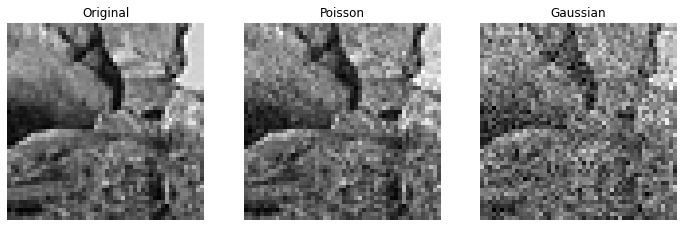

In [12]:
mostrar_lado_a_lado(imagens=[original[3010, :,:], poisson_noisy[3010,:,:], gaussian_noisy[3010, :, :]], titulos=['Original', 'Poisson', 'Gaussian'])

## Normalizing datasets between [0;1]

In [13]:
original = cv2.normalize(original, None, alpha= 0, beta = 1, norm_type = cv2.NORM_MINMAX, dtype = cv2.CV_32F)
poisson_noisy = cv2.normalize(poisson_noisy, None, alpha= 0, beta = 1, norm_type = cv2.NORM_MINMAX, dtype = cv2.CV_32F)
gaussian_noisy = cv2.normalize(gaussian_noisy, None, alpha= 0, beta = 1, norm_type = cv2.NORM_MINMAX, dtype = cv2.CV_32F)

## Adding color dimension

In [14]:
original = adiciona_a_dimensao_das_cores(original)
poisson_noisy = adiciona_a_dimensao_das_cores(poisson_noisy)
gaussian_noisy = adiciona_a_dimensao_das_cores(gaussian_noisy)

In [15]:
original.shape

(30800, 50, 50, 1)

### Loading Poisson noisy data



In [16]:
poisson_com_rl = np.load('results/spie2020/teste-rl/poisson/predicted_with_rl.npy')
poisson_sem_rl = np.load('results/spie2020/teste-rl/poisson/predicted_without_rl.npy')

In [19]:
poisson_psnr_com_rl = np.load('results/spie2020/teste-rl/poisson/psnr_with_rl.npy')
poisson_psnr_sem_rl = np.load('results/spie2020/teste-rl/poisson/psnr_without_rl.npy')

poisson_ssim_com_rl = np.load('results/spie2020/teste-rl/poisson/ssim_with_rl.npy')
poisson_ssim_sem_rl = np.load('results/spie2020/teste-rl/poisson/ssim_without_rl.npy')

### Loading Guassian noisy data

In [37]:
gaussiano_com_rl = np.load('results/spie2020/teste-rl/gaussian/predicted_with_rl.npy')
gaussiano_sem_rl = np.load('results/spie2020/teste-rl/gaussian/predicted_without_rl.npy')

In [38]:
gaussiano_psnr_com_rl = np.load('results/spie2020/teste-rl/gaussian/psnr_with_rl.npy')
gaussiano_psnr_sem_rl = np.load('results/spie2020/teste-rl/gaussian/psnr_without_rl.npy')

gaussiano_ssim_com_rl = np.load('results/spie2020/teste-rl/gaussian/ssim_with_rl.npy')
gaussiano_ssim_sem_rl = np.load('results/spie2020/teste-rl/gaussian/ssim_without_rl.npy')

In [56]:
dados = []

for i in range(len(poisson_psnr_com_rl)):
  dados.append({
      'index': i,
      'method': 'DnCNN',
      'noise': 'Poisson',
      'residual learning': 'with RL',
      'psnr': poisson_psnr_com_rl[i],
      'ssim': poisson_ssim_com_rl[i]
  })

  dados.append({
      'index': i,
      'method': 'DnCNN',
      'noise': 'Poisson',
      'residual learning': 'without RL',
      'psnr': poisson_psnr_sem_rl[i],
      'ssim': poisson_ssim_sem_rl[i]
  })

  dados.append({
      'index': i,
      'method': 'DnCNN',
      'noise': 'Gaussian',
      'residual learning': 'with RL',
      'psnr': gaussiano_psnr_com_rl[i],
      'ssim': gaussiano_ssim_com_rl[i]
  })

  dados.append({
      'index': i,
      'method': 'DnCNN',
      'noise': 'Gaussian',
      'residual learning': 'without RL',
      'psnr': gaussiano_psnr_sem_rl[i],
      'ssim': gaussiano_ssim_sem_rl[i]
  })


In [59]:
df = pd.DataFrame(dados)

## Compairing PSNR and SSIM of Poisson noise

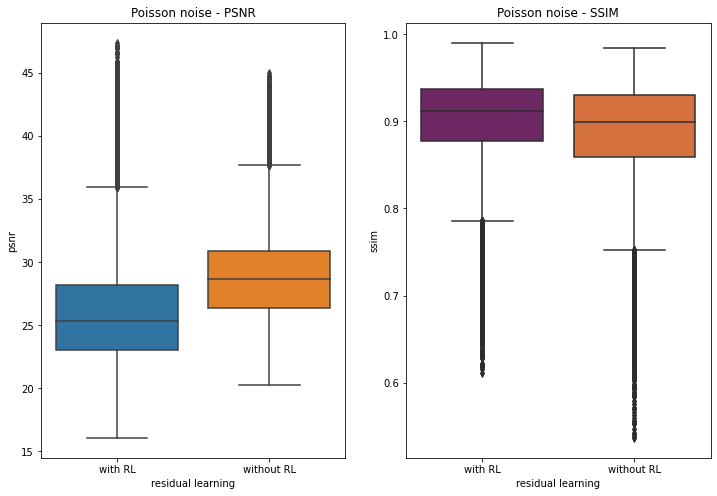

In [60]:
fig, ax = plt.subplots(1,2, figsize=(12,8))
ax[0].set_title('Poisson noise - PSNR')
sns.boxplot(data=df[df['noise'] == 'Poisson'], x='residual learning', y='psnr', ax=ax[0])

ax[1].set_title('Poisson noise - SSIM')
sns.boxplot(data=df[df['noise'] == 'Poisson'], x='residual learning', y='ssim', palette='inferno', ax=ax[1])


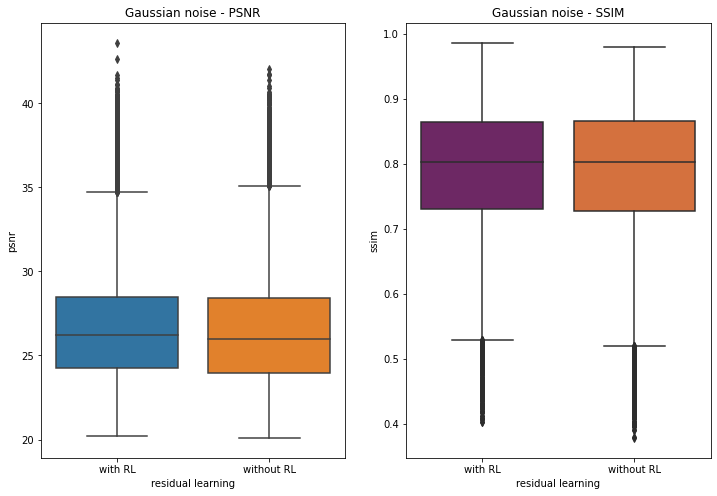

In [61]:
fig, ax = plt.subplots(1,2, figsize=(12,8))
ax[0].set_title('Gaussian noise - PSNR')
sns.boxplot(data=df[df['noise'] == 'Gaussian'], x='residual learning', y='psnr', ax=ax[0])

ax[1].set_title('Gaussian noise - SSIM')
sns.boxplot(data=df[df['noise'] == 'Gaussian'], x='residual learning', y='ssim', palette='inferno', ax=ax[1])


# Compairing Residual Learning influence in DnCNN to Poisson and Gaussian denoising

## Using graphic

Text(0, 0.5, 'SSIM')

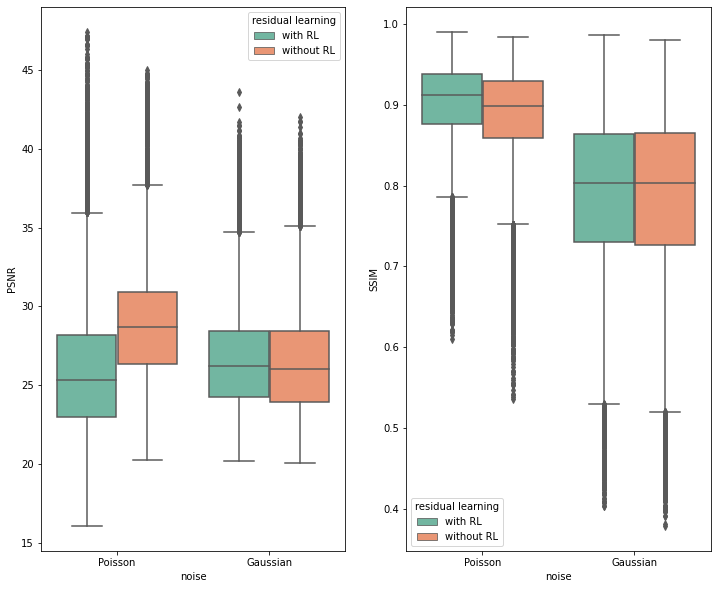

In [110]:
fig, ax = plt.subplots(1,2, figsize=(12,10))
sns.boxplot(data=df, x='noise', y='psnr', hue='residual learning', palette='Set2', ax=ax[0])
ax[0].set_ylabel('PSNR')

sns.boxplot(data=df, x='noise', y='ssim', hue='residual learning', palette='Set2', ax=ax[1])
ax[1].set_ylabel('SSIM')

## Using tables

In [93]:
df.groupby(['noise', 'residual learning'])['psnr'].describe().loc[:, ['mean', 'std', 'min', 'max']]

mean       std        min        max
noise    residual learning                                           
Gaussian with RL            26.587318  3.301448  20.187643  43.602962
         without RL         26.467103  3.406961  20.091316  42.037808
Poisson  with RL            25.866917  4.485230  16.062688  47.406411
         without RL         28.820294  3.700038  20.249835  45.005935

In [90]:
df.groupby(['noise', 'residual learning'])['ssim'].describe().loc[:, ['mean', 'std', 'min', 'max']]

mean       std       min       max
noise    residual learning                                        
Gaussian with RL            0.793118  0.097720  0.402877  0.986149
         without RL         0.790951  0.101304  0.378302  0.980225
Poisson  with RL            0.900557  0.052839  0.610523  0.990526
         without RL         0.886780  0.062260  0.536210  0.984505

## Visual comparison

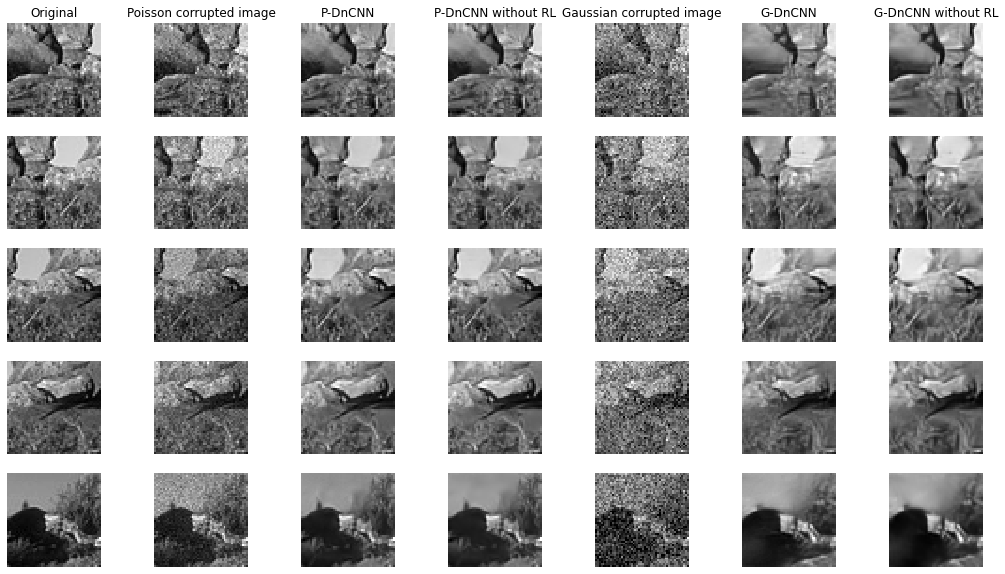

In [109]:
INDEX_IMAGEM = 3010 
QUANTIDADE_IMAGENS = 5

fig, ax = plt.subplots(QUANTIDADE_IMAGENS,7, figsize=(18,10))

for i in range(QUANTIDADE_IMAGENS):

  if i == 0:
    ax[i,0].set_title('Original')
  ax[i,0].axis('off')
  ax[i,0].imshow(original[INDEX_IMAGEM+i, :, :, 0], cmap='gray', interpolation='nearest')

  if i == 0:
    ax[i,1].set_title('Poisson corrupted image')
  ax[i,1].axis('off')
  ax[i,1].imshow(poisson_noisy[INDEX_IMAGEM+i, :, :, 0], cmap='gray', interpolation='nearest')

  if i == 0:
    ax[i,2].set_title('P-DnCNN')
  ax[i,2].axis('off')
  ax[i,2].imshow(poisson_com_rl[INDEX_IMAGEM+i, :, :, 0], cmap='gray', interpolation='nearest')

  if i == 0:
    ax[i,3].set_title('P-DnCNN without RL')
  ax[i,3].axis('off')
  ax[i,3].imshow(poisson_sem_rl[INDEX_IMAGEM+i, :, :, 0], cmap='gray', interpolation='nearest')

  if i == 0:
    ax[i,4].set_title('Gaussian corrupted image')
  ax[i,4].axis('off')
  ax[i,4].imshow(gaussian_noisy[INDEX_IMAGEM+i, :, :, 0], cmap='gray', interpolation='nearest')

  if i == 0:
    ax[i,5].set_title('G-DnCNN')
  ax[i,5].axis('off')
  ax[i,5].imshow(gaussiano_com_rl[INDEX_IMAGEM+i, :, :, 0], cmap='gray', interpolation='nearest')

  if i == 0:
    ax[i,6].set_title('G-DnCNN without RL')
  ax[i,6].axis('off')
  ax[i,6].imshow(gaussiano_sem_rl[INDEX_IMAGEM+i, :, :, 0], cmap='gray', interpolation='nearest')


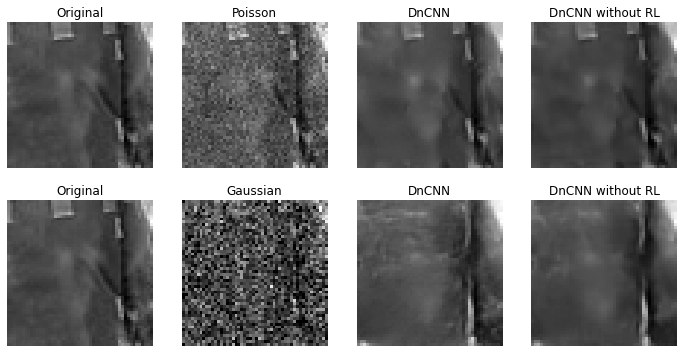

In [98]:
INDEX_IMAGEM = 500 

fig, ax = plt.subplots(2,4, figsize=(12,6))


ax[0,0].set_title('Original')
ax[0,0].axis('off')
ax[0,0].imshow(original[INDEX_IMAGEM, :, :, 0], cmap='gray', interpolation='nearest')

ax[0,1].set_title('Poisson')
ax[0,1].axis('off')
ax[0,1].imshow(poisson_noisy[INDEX_IMAGEM, :, :, 0], cmap='gray', interpolation='nearest')


ax[0,2].set_title('DnCNN')
ax[0,2].axis('off')
ax[0,2].imshow(poisson_com_rl[INDEX_IMAGEM, :, :, 0], cmap='gray', interpolation='nearest')


ax[0,3].set_title('DnCNN without RL')
ax[0,3].axis('off')
ax[0,3].imshow(poisson_sem_rl[INDEX_IMAGEM, :, :, 0], cmap='gray', interpolation='nearest')

ax[1,0].set_title('Original')
ax[1,0].axis('off')
ax[1,0].imshow(original[INDEX_IMAGEM, :, :, 0], cmap='gray', interpolation='nearest')

ax[1,1].set_title('Gaussian')
ax[1,1].axis('off')
ax[1,1].imshow(gaussian_noisy[INDEX_IMAGEM, :, :, 0], cmap='gray', interpolation='nearest')


ax[1,2].set_title('DnCNN')
ax[1,2].axis('off')
ax[1,2].imshow(gaussiano_com_rl[INDEX_IMAGEM, :, :, 0], cmap='gray', interpolation='nearest')


ax[1,3].set_title('DnCNN without RL')
ax[1,3].axis('off')
ax[1,3].imshow(gaussiano_sem_rl[INDEX_IMAGEM, :, :, 0], cmap='gray', interpolation='nearest')